In [9]:
import pickle
import numpy as np
pickle_in = open("dataset_pickle\X_bot.pickle","rb")
X_bot = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\X_top.pickle","rb")
X_top = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_multimodal.pickle","rb")
y = pickle.load(pickle_in)


# X_top = X_top/255.0
# X_bot = X_bot/255.0

print(X_top.shape)
print(X_bot.shape)

(1920, 100, 100, 1)
(1920, 100, 100, 1)


In [10]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [11]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
#Setup Distrbuited training
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())   #Enables

2 Physical GPUs, 2 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [12]:
# Merged image
from cv2 import cv2
X = np.concatenate((X_bot, X_top ), axis=3)
print(X.shape)
#mat= (X[0][:][:])
#print(mat)
# cv2.imshow('img',mat)


(1920, 100, 100, 2)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout #, GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from sklearn.model_selection import StratifiedKFold #for K-fold cross validation
import numpy


tf.random.set_seed(42)

Resolution = 100

numpy.random.seed(7)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []

for train, test in kfold.split(X, y):
    with strategy.scope():      #Enables multi-gpu
            model = Sequential([
                Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu', input_shape=(Resolution, Resolution, 2)),
                MaxPooling2D(pool_size=(1, 5), strides=(4)),

                Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
                MaxPooling2D(pool_size=(1, 4), strides=(2)),

                Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
                MaxPooling2D(pool_size=(1, 2), strides=(2)),

                Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
                MaxPooling2D(pool_size=(2, 2), strides=(2)),

                Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
                MaxPooling2D(pool_size=(1, 2), strides=(2)),

                Flatten(),
                #Dense(32, activation='relu'),

                Dense(6, activation='softmax')
            ])


            model.compile(loss='sparse_categorical_crossentropy',
                        optimizer=optimizers.Adam(learning_rate=0.001),                  #gradient descent
                        metrics=['accuracy'])
            lr_change = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=0.000)
            early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=10, mode='min')
            callbacks = [lr_change,early_stopping]
            history = model.fit(X[train], y[train], batch_size=16, epochs=200,callbacks=callbacks)
            scores = model.evaluate(X[test], y[test], verbose=0)
            print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
            cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
    #model.summary() 

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/200
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:

In [78]:
history = model.fit(X, labels, batch_size=16, epochs=200, validation_split=0.2,callbacks=callbacks)
# history = model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test,y_test),callbacks=callbacks)

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
96/96 [==============================] - 5s 13ms/step - loss: 1.7808 - accuracy: 0.4296 - val_loss: 0.8126 - val_accuracy: 0.7109
Epoch 2/200
96/96 [==============================] - 1s 10ms/step - loss: 0.7371 - accuracy: 0.7061 - val_loss: 0.5543 - val_accuracy: 0.7865
Epoch 3/200
96/96 [==============================] - 1s 11ms/step - loss: 0.4365 - accuracy: 0.8097 - val_loss: 0.4135 - val_accuracy: 0.8516
Epoch 4/200
96/96 [==============================] - 1s 11ms/step - loss: 0.3552 - accuracy: 0.8642 - val_loss: 0.2948 - val_accuracy: 0.8958
Epoch 5/200
96/96 [==============================] - 1s 11ms/step - loss: 0.2761 - accuracy: 0.8929 - val_loss: 0.4357 - val_accuracy: 0.8099
Epoch 6/200
96/96 [==============================] - 1s 11ms/step - loss: 0.3318 - accuracy:

60/60 - 1s - loss: 0.0280 - accuracy: 0.9911
60/60 [==============================] - 0s 7ms/step - loss: 0.0280 - accuracy: 0.9911


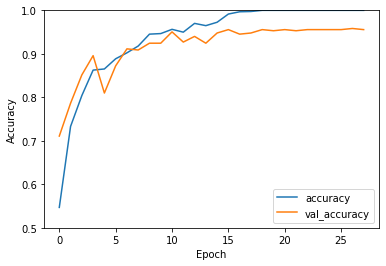

In [80]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X,  labels, verbose=2)
preds = model.evaluate(X, labels,verbose=1, sample_weight=None)

In [81]:
model.save("models\model_early_fusion.h5")
print("model saved")

model saved


In [82]:
from keras.models import load_model
# load model
model = load_model('models\model_early_fusion.h5')
# summarize model.
#model.summary()

In [87]:
# evaluate the model
import pickle
pickle_in = open("dataset_pickle\X_bot_user.pickle","rb")
X_test_bot = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\X_top_user.pickle","rb")
X_test_top = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_multimodal_user.pickle","rb")
y_test = pickle.load(pickle_in)

X_test = np.concatenate((X_test_bot,X_test_top),axis=3)

# X_test_bot = X_test_bot/255.0
# X_test_top = X_test_top/255.0

score = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

8/8 - 0s - loss: 12.6226 - accuracy: 0.2125
accuracy: 21.25%


In [22]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,rankdir='LR')

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
y_pred = model.predict(X_test)
rounded_labels=np.argmax(y_pred, axis=1)
print(rounded_labels.shape)
confusion = confusion_matrix(y_test, rounded_labels)

(240,)


In [11]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35  0  0  0  3  2]
 [ 0 31  1  0  7  1]
 [ 0  0 40  0  0  0]
 [ 0  0  0 40  0  0]
 [ 1  5  0  0 34  0]
 [ 1  0  0  0  1 38]]


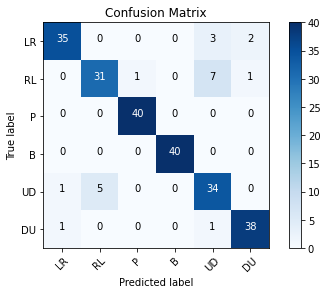

In [12]:
import itertools
Classes = ["LR", "RL", "P", "B", "UD", "DU"]
plot_confusion_matrix(cm=confusion,title='Confusion Matrix', classes=Classes)
#plot.savefig('plot_confusion_matrix.png')